# lighteval is your AI evaluation library

This notebook explores how you can use lighteval to evaluate and compare LLMs.

`lighteval` has been around a while and it's a great tool for getting eval score on major benchmarks. It's just been refactored to support being used like a library in Python, which makes it great for comparing models across benchmarks.

So let's dig in to some eval scores.

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Exercise: Evaluate Your Own Model</h2>
    <p>Now that you've seen how to evaluate models on specific domains, try evaluating a model on a domain that interests you.</p>
    <p><b>Difficulty Levels</b></p>
    <p>🐢 Use the existing medical domain tasks but evaluate a different model from the Hugging Face hub</p>
    <p>🐕 Create a new domain evaluation by selecting different MMLU tasks (e.g., computer science, mathematics, physics)</p>
    <p>🦁 Create a custom evaluation task using LightEval's task framework and evaluate models on your specific domain</p>
</div>

## Install dependencies

In [2]:
!pip install uv

  Obtaining dependency information for uv from https://files.pythonhosted.org/packages/ee/40/59e9c03431d4c82420e081f92719e5784db8f1c92a25b2abdfe6ac645b7e/uv-0.6.2-py3-none-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 51.9 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!uv pip install -U "torch<2.5" "torchvision<2.5" "torchaudio<2.5"

Using Python 3.11.7 environment at: /Users/user/personal/2025/smol-course/.venv
Resolved 13 packages in 283ms                                        
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)----     0 B/1.71 MiB                      
⠙ Preparing packages... (0/1)---- 14.91 KiB/1.71 MiB                    
⠙ Preparing packages... (0/1)---- 30.91 KiB/1.71 MiB                    
⠙ Preparing packages... (0/1)---- 46.91 KiB/1.71 MiB                    
⠙ Preparing packages... (0/1)---- 62.91 KiB/1.71 MiB                    
⠙ Preparing packages... (0/1)---- 78.91 KiB/1.71 MiB                    
⠙ Preparing packages... (0/1)---- 94.91 KiB/1.71 MiB                    
⠙ Preparing packages... (0/1)---- 110.91 KiB/1.71 MiB                   
⠙ Preparing packages... (0/1)---- 126.91 KiB/1.71 MiB                   
⠙ Preparing packages... (0/1)---- 142.91 KiB/1.71 MiB                   
⠙ Preparing packages... (0/1)---- 158.9

In [4]:
!uv pip install lighteval tiktoken

Using Python 3.11.7 environment at: /Users/user/personal/2025/smol-course/.venv
Resolved 102 packages in 1.27s                                       
⠙ Preparing packages... (0/88)                                                  
⠙ Preparing packages... (0/88)---     0 B/10.80 MiB                     
⠙ Preparing packages... (0/88)--- 16.00 KiB/10.80 MiB                   
⠙ Preparing packages... (0/88)--- 32.00 KiB/10.80 MiB                   
⠙ Preparing packages... (0/88)--- 48.00 KiB/10.80 MiB                   
⠙ Preparing packages... (0/88)--- 64.00 KiB/10.80 MiB                   
⠙ Preparing packages... (0/88)--- 80.00 KiB/10.80 MiB                   
⠙ Preparing packages... (0/88)--- 96.00 KiB/10.80 MiB                   
⠙ Preparing packages... (0/88)--- 112.00 KiB/10.80 MiB                  
⠙ Preparing packages... (0/88)--- 128.00 KiB/10.80 MiB                  
pytz       ------------------------------     0 B/496.03 KiB
⠙ Preparing packages... (0/88)--- 128.00 KiB/10.80 

## Setup `lighteval` evaluation

We need to setup the evaluation environment and pipeline. Much of this we will disable because we're keeping things in the notebook, but we could also use `push_to_hub` or `push_to_tensorboard`.

### `push_to_hub`

This is useful if we're evaluating a model and want to persist its evaluation with weights and configuration on the Hugging Face hub.

### `push_to_tensorboard`

This would be useful if we were building an evaluation tool or script, where we wanted to view results within tensorboard.

In [6]:
!pip install ipywidgets

  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/22/2d/9c0b76f2f9cc0ebede1b9371b6f317243028ed60b90705863d493bae622e/ipywidgets-8.1.5-py3-none-any.whl.metadata
  Obtaining dependency information for widgetsnbextension~=4.0.12 from https://files.pythonhosted.org/packages/21/02/88b65cc394961a60c43c70517066b6b679738caf78506a5da7b88ffcb643/widgetsnbextension-4.0.13-py3-none-any.whl.metadata
  Obtaining dependency information for jupyterlab-widgets~=3.0.12 from https://files.pythonhosted.org/packages/a9/93/858e87edc634d628e5d752ba944c2833133a28fa87bb093e6832ced36a3e/jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata
Using cached ipywidgets-8.1.5-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl (214 kB)
Using cached widgetsnbextension-4.0.13-py3-none-any.whl (2.3 MB)

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import lighteval
import os
from datetime import timedelta
from transformers import AutoModelForCausalLM

from lighteval.logging.evaluation_tracker import EvaluationTracker

# from lighteval.logging.hierarchical_logger import hlog_warn, htrack
# from lighteval.models.model_config import create_model_config
from lighteval.pipeline import (
    EnvConfig,
    ParallelismManager,
    Pipeline,
    PipelineParameters,
)

os.environ["HF_TOKEN"]
TOKEN = os.getenv("HF_TOKEN")

tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/783 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

In [2]:
env_config = EnvConfig(token=TOKEN, cache_dir="~/tmp")

evaluation_tracker = EvaluationTracker(
    output_dir="~/tmp",
    save_details=False,
    push_to_hub=False,
    push_to_tensorboard=False,
    public=False,
    hub_results_org=False,
)

pipeline_params = PipelineParameters(
    launcher_type=ParallelismManager.ACCELERATE,
    env_config=env_config,
    job_id=1,
    override_batch_size=1,
    num_fewshot_seeds=0,
    max_samples=10,
    use_chat_template=False,
)

# Compares models with `lighteval`

We are going to compare two small LLMs on a domain. We will use `Qwen2.5-0.5B` and `SmolLM2-360M-Instruct` and we will evaluate them on a medical domain.

We can create a domain evaluation from a subset of MMLU evaluations, by defining the evaluation tasks. In lighteval, tasks are described as strings.

`{suite}|{task}:{subtask}|{num_few_shot}|{0 or 1 to reduce num_few_shot if prompt is too long}`

Therefore, we will pass our list of medicine related tasks like this:

```
"leaderboard|mmlu:anatomy|5|0,leaderboard|mmlu:professional_medicine|5|0,leaderboard|mmlu:high_school_biology|5|0,leaderboard|mmlu:high_school_chemistry|5|0"
```

Which can be translated to :

| Suite | Task | Num Fewshot Example | Limit Fewshots |
|---|---|---|---|
| leaderboard | mmlu:anatomy | 5 | False |
| leaderboard | mmlu:professional_medicine | 5 | False |
| leaderboard | mmlu:high_school_biology | 5 | False |
| leaderboard | mmlu:high_school_chemistry | 5 | False |

For a full list of lighteval supported tasks. Checkout this page in [the documentation](https://github.com/huggingface/lighteval/wiki/Available-Tasks).

In [13]:
domain_tasks = "leaderboard|mmlu:anatomy|20|0,leaderboard|mmlu:professional_medicine|20|0,leaderboard|mmlu:high_school_biology|20|0,leaderboard|mmlu:high_school_chemistry|20|0"

# Evaluate Qwen2.5 0.5B

In [14]:
qwen_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-0.5B")

pipeline = Pipeline(
    tasks=domain_tasks,
    pipeline_parameters=pipeline_params,
    evaluation_tracker=evaluation_tracker,
    model=qwen_model,
)

pipeline.evaluate()

qwen_results = pipeline.get_results()

--max_samples WAS SET. THESE NUMBERS ARE ONLY PARTIAL AND SHOULD NOT BE USED FOR COMPARISON UNLESS YOU KNOW WHAT YOU ARE DOING.
Problem when loading the tokenizer in the cache - discarding the provided cache path value.
If you want to use extended_tasks, make sure you installed their dependencies using `pip install -e .[extended_tasks]`.
Token indices sequence length is longer than the specified maximum sequence length for this model (334 > 20). Running this sequence through the model will result in indexing errors
100%|██████████| 40/40 [00:03<00:00, 12.02it/s]
4it [00:13,  3.37s/it]


In [15]:
pipeline.show_results()

|                  Task                   |Version|Metric|Value |   |Stderr|
|-----------------------------------------|------:|------|-----:|---|-----:|
|all                                      |       |acc   |0.3273|±  |0.1212|
|leaderboard:mmlu:_average:20             |       |acc   |0.3000|±  |0.1408|
|leaderboard:mmlu:_average:5              |       |acc   |0.3480|±  |0.1063|
|leaderboard:mmlu:anatomy:20              |      0|acc   |0.5000|±  |0.1667|
|leaderboard:mmlu:anatomy:5               |      0|acc   |0.4500|±  |0.1141|
|leaderboard:mmlu:high_school_biology:20  |      0|acc   |0.1000|±  |0.1000|
|leaderboard:mmlu:high_school_biology:5   |      0|acc   |0.1500|±  |0.0819|
|leaderboard:mmlu:high_school_chemistry:20|      0|acc   |0.2000|±  |0.1333|
|leaderboard:mmlu:high_school_chemistry:5 |      0|acc   |0.3500|±  |0.1094|
|leaderboard:mmlu:professional_medicine:20|      0|acc   |0.4000|±  |0.1633|
|leaderboard:mmlu:professional_medicine:5 |      0|acc   |0.4500|±  |0.1141|

In [16]:
qwen_results

{'config_general': {'lighteval_sha': '?',
  'num_fewshot_seeds': 0,
  'override_batch_size': 1,
  'max_samples': 10,
  'job_id': 1,
  'start_time': 1401132.133479791,
  'end_time': 1401575.69736875,
  'total_evaluation_time_secondes': '443.56388895912096',
  'model_name': 'Qwen/Qwen2.5-0.5B',
  'model_sha': '060db6499f32faf8b98477b0a26969ef7d8b9987',
  'model_dtype': torch.float32,
  'model_size': '1.84 GB',
  'config': None},
 'results': {'leaderboard:mmlu:anatomy:5': defaultdict(float,
              {'acc': 0.45, 'acc_stderr': 0.11413288653790232}),
  'leaderboard:mmlu:high_school_biology:5': defaultdict(float,
              {'acc': 0.15, 'acc_stderr': 0.08191780219091252}),
  'leaderboard:mmlu:high_school_chemistry:5': defaultdict(float,
              {'acc': 0.35, 'acc_stderr': 0.1094243309804831}),
  'leaderboard:mmlu:professional_medicine:5': defaultdict(float,
              {'acc': 0.45, 'acc_stderr': 0.11413288653790232}),
  'leaderboard:mmlu:_average:5': {'acc': 0.348,
   'acc

# Evaluate SmolLM 360M

In [17]:
smol_model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-360M-Instruct")

pipeline = Pipeline(
    tasks=domain_tasks,
    pipeline_parameters=pipeline_params,
    evaluation_tracker=evaluation_tracker,
    model=smol_model,
)

pipeline.evaluate()

--max_samples WAS SET. THESE NUMBERS ARE ONLY PARTIAL AND SHOULD NOT BE USED FOR COMPARISON UNLESS YOU KNOW WHAT YOU ARE DOING.
Problem when loading the tokenizer in the cache - discarding the provided cache path value.
If you want to use extended_tasks, make sure you installed their dependencies using `pip install -e .[extended_tasks]`.
Token indices sequence length is longer than the specified maximum sequence length for this model (341 > 20). Running this sequence through the model will result in indexing errors
100%|██████████| 40/40 [00:03<00:00, 11.71it/s]
4it [00:14,  3.67s/it]


In [18]:
smol_results = pipeline.get_results()

In [19]:
smol_results

{'config_general': {'lighteval_sha': '?',
  'num_fewshot_seeds': 0,
  'override_batch_size': 1,
  'max_samples': 10,
  'job_id': 1,
  'start_time': 1401132.133479791,
  'end_time': 1401600.160338833,
  'total_evaluation_time_secondes': '468.0268590420019',
  'model_name': 'HuggingFaceTB/SmolLM2-360M-Instruct',
  'model_sha': '29ba36fc600930f3cfe6e1a93ab43af299542dc4',
  'model_dtype': torch.float32,
  'model_size': '1.35 GB',
  'config': None},
 'results': {'leaderboard:mmlu:anatomy:5': defaultdict(float,
              {'acc': 0.45, 'acc_stderr': 0.11413288653790232}),
  'leaderboard:mmlu:high_school_biology:5': defaultdict(float,
              {'acc': 0.15, 'acc_stderr': 0.08191780219091252}),
  'leaderboard:mmlu:high_school_chemistry:5': defaultdict(float,
              {'acc': 0.35, 'acc_stderr': 0.1094243309804831}),
  'leaderboard:mmlu:professional_medicine:5': defaultdict(float,
              {'acc': 0.45, 'acc_stderr': 0.11413288653790232}),
  'leaderboard:mmlu:_average:5': {'ac

In [20]:
pipeline.show_results()

|                  Task                   |Version|Metric|Value |   |Stderr|
|-----------------------------------------|------:|------|-----:|---|-----:|
|all                                      |       |acc   |0.3432|±  |0.1098|
|leaderboard:mmlu:_average:20             |       |acc   |0.3400|±  |0.1121|
|leaderboard:mmlu:_average:5              |       |acc   |0.3496|±  |0.1052|
|leaderboard:mmlu:anatomy:20              |      0|acc   |0.4500|±  |0.1141|
|leaderboard:mmlu:anatomy:5               |      0|acc   |0.4500|±  |0.1141|
|leaderboard:mmlu:high_school_biology:20  |      0|acc   |0.1500|±  |0.0819|
|leaderboard:mmlu:high_school_biology:5   |      0|acc   |0.1500|±  |0.0819|
|leaderboard:mmlu:high_school_chemistry:20|      0|acc   |0.3500|±  |0.1094|
|leaderboard:mmlu:high_school_chemistry:5 |      0|acc   |0.3500|±  |0.1094|
|leaderboard:mmlu:professional_medicine:20|      0|acc   |0.4500|±  |0.1141|
|leaderboard:mmlu:professional_medicine:5 |      0|acc   |0.4500|±  |0.1141|

# Visualize Results

Now that we have results from the two models we can visualize them side-by-side. We'll keep visualisation simple here, but with this data structure you could represent scores in many ways.

In [21]:
# !pip install matplotlib

<Axes: >

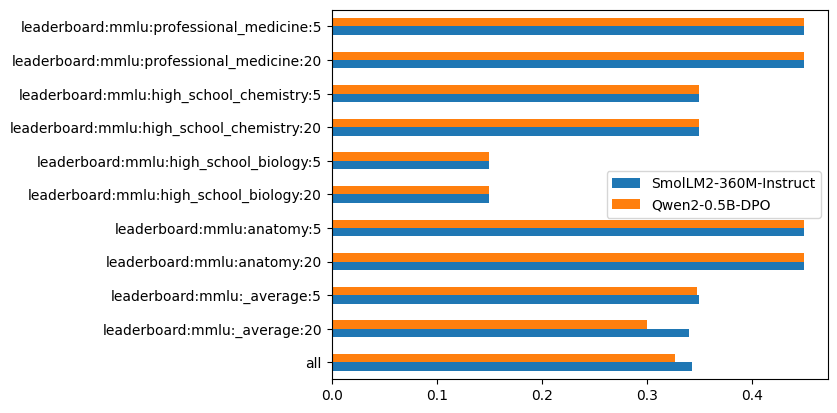

In [22]:
import pandas as pd

df = (
    pd.DataFrame.from_records(smol_results["results"])
    .T["acc"]
    .rename("SmolLM2-360M-Instruct")
)
_df = (
    pd.DataFrame.from_records(qwen_results["results"]).T["acc"].rename("Qwen2-0.5B-DPO")
)
df = pd.concat([df, _df], axis=1)
df.plot(kind="barh")

# 💐 That's it!

You have a handy notebook to view model evals. You could use this to:

- select the right model for your inference use case
- evaluate checkpoints during training
- share model scores

🏃Next Steps

- If you want to go deeper into your evaluation results check out this [notebook](https://github.com/huggingface/evaluation-guidebook/blob/main/contents/examples/comparing_task_formulations.ipynb)
